# Find patterns by use in heatmap
In this notebook the following tasks will be accomplished:

1. Remove atypical dates and buiding-dates (see notebook `02_find-patterns-by-site`)
2. Plot heatmaps grouped by `primary_use` (one per meter)

In [1]:
import sys
sys.path.append("..\\source\\")
import utils as utils
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
path_data = "..\\data\\processed\\summary\\"
path_leak = "..\\data\\leaked\\"
path_meta = "..\\data\\original\\metadata\\"
path_res = "..\\results\\"
path_fig = "..\\figures\\"

## Leaked data

In [3]:
# Load data
leak_chilledwater = pd.read_csv(path_leak + "leak_electricity.csv")
leak_electricity = pd.read_csv(path_leak + "leak_electricity.csv")
leak_hotwater = pd.read_csv(path_leak + "leak_hotwater.csv")
leak_steam = pd.read_csv(path_leak + "leak_steam.csv")

## Metadata

In [4]:
# Buildings metadata
meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
meta_bdg = utils.reduce_mem_usage(meta_bdg)

Mem. usage decreased to  0.03 Mb (60.3% reduction)


## Plots

In [5]:
meter = "chilledwater"
leak = eval(f"leak_{meter}")

# Load data
df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")
# Remove leaked buidings
df = df[df.building_id.isin(leak.building_id) == False]
# Datetime object
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S")
# Complete missing dates
df = utils.completeData(df,"2017-01-01","2018-12-31")
# Merge with metadata
df = pd.merge(df, meta_bdg, how="left", on="building_id")
# Scale metric between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_rmsle = scaler.fit_transform(np.array(df.rmsle).reshape(-1, 1))
# Add to df
df["rmsle_scaled"] = scaled_rmsle
print(f"Min rmsle: {df.rmsle.min()}. Max rmsle: {df.rmsle.max()}")
print(f"Min rmsle_scaled: {df.rmsle_scaled.min()}. Max rmsle_scaled: {df.rmsle_scaled.max()}")

# Patterns data
# Weird dates
pdates = pd.read_csv(path_res + f"{meter}_dates.csv").rename(columns={"date":"timestamp"})
pdates.timestamp = pd.to_datetime(pdates.timestamp, format="%Y-%m-%d")
# Weird buildings-dates
pbdg = pd.read_csv(path_res + f"{meter}_bdg.csv").rename(columns={"date":"timestamp"})
pbdg.timestamp = pd.to_datetime(pbdg.timestamp, format="%Y-%m-%d")

# Merge with weird dates
df1 = df[["site_id","building_id","timestamp","rmsle_scaled","primary_use"]]
df1 = pd.merge(df1,pdates,how="left",on=["timestamp","site_id"])
# Remove wird dates (replaced with nan)
df1.loc[df1.sum_val.isna() == False,"rmsle_scaled"] = np.nan

# Merge with weird buildings-dates
df1 = pd.merge(df1,pbdg,how="left",on=["timestamp","site_id","building_id"])
# Remove wird buildings-dates (replaced with nan)
df1.loc[df1.grp.isna() == False,"rmsle_scaled"] = np.nan

# Drop useless columns
df1.drop(["sum_val","grp"],axis=1,inplace=True)

Min rmsle: 0.03130454570055008. Max rmsle: 8.397016525268555
Min rmsle_scaled: 0.0. Max rmsle_scaled: 1.0


['Education', 'Office', 'Public services', 'Entertainment/public assembly', 'Lodging/residential', 'Other', 'Technology/science', 'Healthcare', 'Parking', 'Food sales and service', 'Manufacturing/industrial']
11


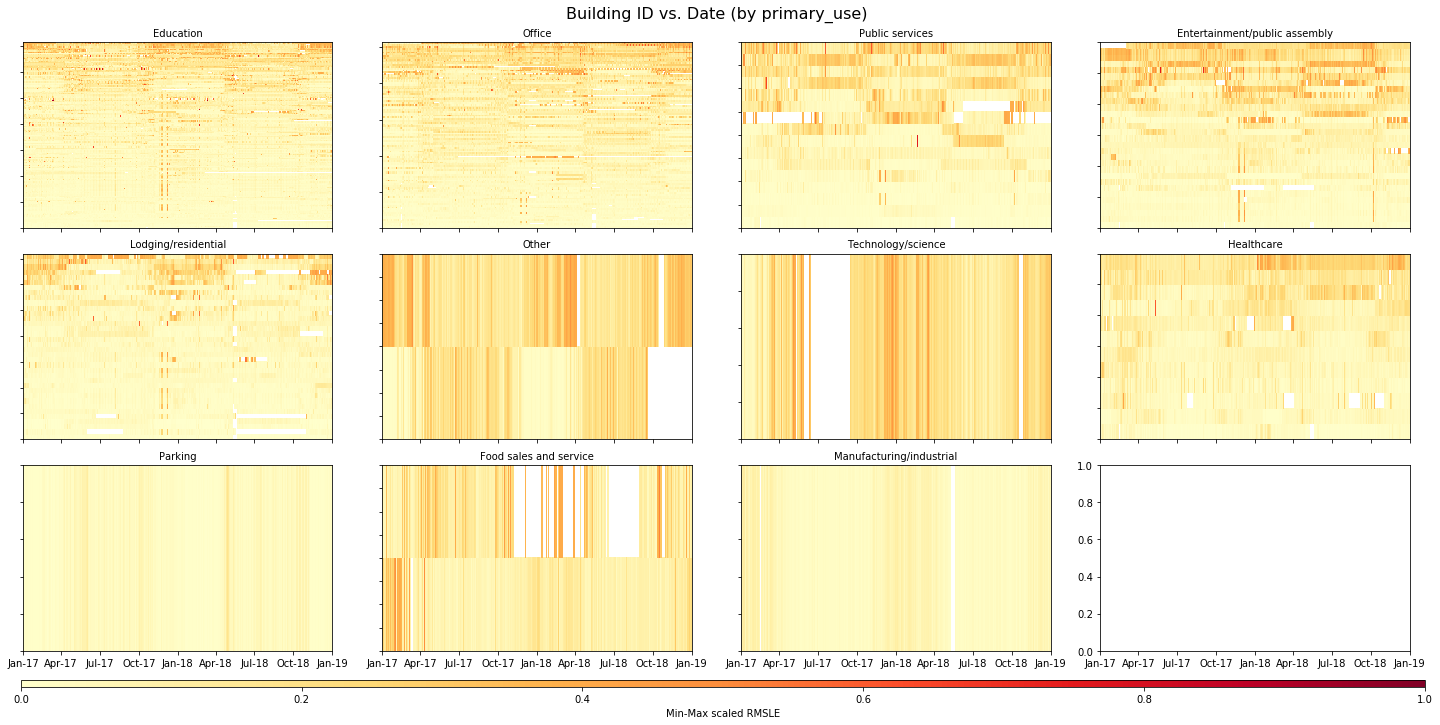

In [7]:
fig = utils.plotHeatmap("primary_use",df1,4)
fig.savefig(path_fig + f"{meter}_use_anomalies-removed.png", bbox_inches='tight', dpi=200)